NLP model (Sub category of ML), many applications.

# Model Goal

### Given a defect title (name) => predict the team that this defect belongs to

Baseline, Similar models can be built for other fields / labels (but team is simple)

The model is built and trained using defects data from center. 

## Required libraries
Main Libs: keras, sklearn, nltk, numpy, pandas

In [1132]:
import keras 
from keras.models import Sequential
from keras.layers import Activation
from keras.optimizers import Adam
from keras import regularizers
from keras.layers import Dense, GlobalAveragePooling1D, Embedding, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn import model_selection
from sklearn import metrics
from keras.metrics import categorical_crossentropy
from sklearn.model_selection import train_test_split
import pandas as pd
import json
import numpy as np
import os

in order to install NLTK stop words, run the following python commands -

import nltk
nltk.download()

# load data from dataset

### Center Workspace, using rest API (Json) / Odata (Excel)

In [1133]:
# Reads and converts json / Excel format to python dict.
def js_r(data):
   with open(data, encoding='utf-8') as f_in:
       return(json.load(f_in))

def read_excel(path):
    return pd.read_excel(open(path, 'rb'),
                  sheet_name='Sheet2')  # doctest: +SKIP

# load JSON data
# data_path=r'C:\dev\defects.json'
# my_dic_data = js_r(data_path)['data']

# Load EXCEL data:
data_path = r'datasets' + os.sep + 'defects-all-spread.xlsx'
my_dic_data = read_excel(data_path)
print('There are: ' + str(len(my_dic_data)) + ' records of defects in dataset.')

There are: 28970 records of defects in dataset.


# Clean the dataset

removing defects without labels, removing label anommalies (single labels)

In [1134]:
# build dataframe from dict
df = pd.DataFrame(my_dic_data)
# cleaning rows without labels OR descritpion
df = df[df['team.id'].map(lambda x: x != None)]
df = df[df['name'].map(lambda x: x != None)]
train_df = df[df['description'].map(lambda x: x != None)]
print("Original dataset shape is: " + str(train_df.shape))

# minimize data set
train_df = train_df[train_df['creation_time'].map(lambda x: x.year >= 2017)]
train_df = train_df.groupby('team.id').filter(lambda x : len(x)>2)
print("Small dataset shape is: " + str(train_df.shape))

# building translation map from team id -> team name
team_id_to_name_map = pd.Series(df['team.name'].values,index=df['team.id']).to_dict()
# spliting Lables from features
X = train_df.drop(['team.id'], axis=1)
Y = train_df['team.id']

train_df.head(n=2)

Original dataset shape is: (28970, 18)
Small dataset shape is: (22251, 18)


,creation_time,id,name,description,knowledge_modified_udf,parent.name,parent.id,release.id,team.id,team.name,product_areas.id,product_areas.name,application_modules.id,application_modules.name,qa_owner.id,qa_owner.name,owner.id,owner.name
0,2017-01-11 09:05:12,205022,[Regression Day - Firefox] - Exception thrown ...,&lt;html&gt;&lt;body&gt;&lt;p&gt;1. create tes...,NaT,Requirement Backlog,1001,22001.0,3002.0,OMG Yuval (Do Not Use),78018.0,10 Tests,78018.0,10 Tests,NaN,NaN,9001.0,sari.bivas@microfocus.com
2,2017-11-06 10:37:27,480023,No data is displayed when clicking on columns ...,&lt;html&gt;&lt;body&gt;&lt;p&gt;Add custom gr...,NaT,Requirement Backlog,1001,48001.0,2001.0,OCD Ido (Do Not Use),80006.0,Custom Graph,80006.0,Custom Graph,105004.0,raluca-maria.negrea@microfocus.com,56015.0,ido.gadiel@hpe.com


Transforming relations to labels, remove unused columns

In [1135]:
def transform_data(data_list):
    print(len(data_list))
    for defect in my_dic_data:
        for column in defect.keys():
            if not defect[column] == None and type(defect[column]) is dict and 'id' in defect[column]:
                defect[column] = defect[column]['id']
        
    return pd.DataFrame(my_dic_data).drop(['access_granted', 'blocked_reason', 'path', 'phase',
                                           'blocked', 'original_id', 'priority', 'defect_root_level', 'story_points', 'user_tags', 'program', 'taxonomies', 'version_stamp', 'detected_in_build', 'sprint', 'dependency_problem_type', 'defect_type'], axis=1)
# df = transform_data(my_dic_data)

# Know the data

### Team defect distribution

1. Is the real world distribution is similar to my training set?

2. look for anomalies? (team with small amount of labels)

3. What to expact? (score)

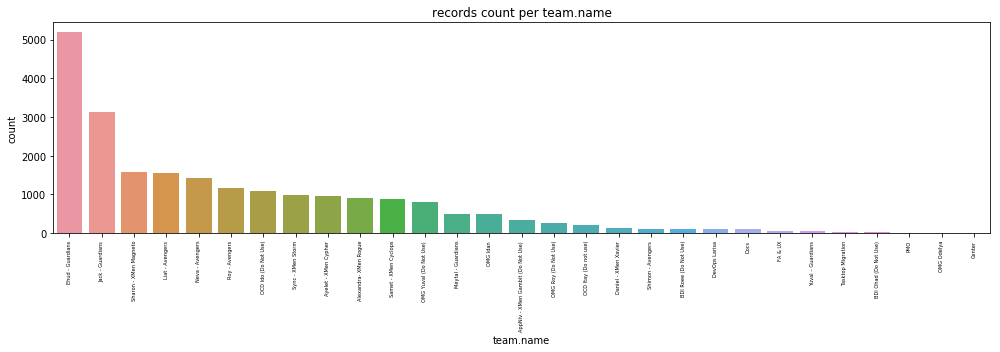

In [1136]:
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
all_labels_image_name = 'gifs' + os.sep + 'team_bar_plot.pdf'

def author_bar_plot(train_df, column):
    fig = plt.gcf()
    fig.set_size_inches(14, 5)
    sns.countplot(x=train_df[column], order=train_df[column].value_counts().index).set_title(
        'records count per ' + column)
    plt.xticks(rotation='vertical', fontsize=5)
    fig.tight_layout()
    fig.savefig(all_labels_image_name, format='pdf')
    plt.close()
    return fig
    
author_bar_plot(train_df, 'team.name')

as we have 6K documents labeled for Ehud team, a majority classifier score will be ~6000 / 28K == 20% Accuracy!

For uniformed distributed data, Majority classifier will output 2% Accuracy

In addition, we can notice for some low frequency annomalies (team with minimal number of defects), consider cleaning?

### Frequent words

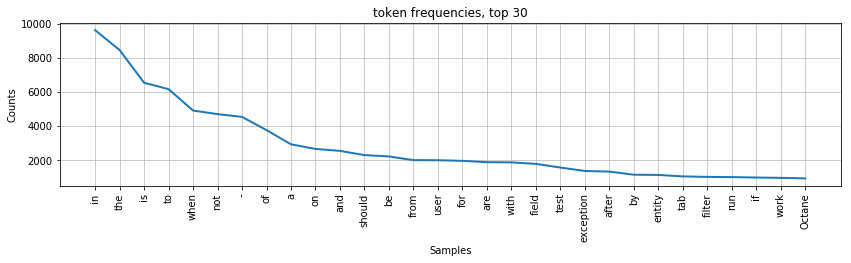

In [1137]:
all_tokens_image_name = 'gifs' + os.sep + 'team_token_plot.pdf'
def plot_token_frequencies(train_df, referance_column='name', title_prefix='',
                           output_path=all_tokens_image_name):
    fig = plt.gcf()
    fig.set_size_inches(14, 3)
    fd = nltk.FreqDist([y for x in train_df[referance_column].str.split() for y in x])
    if title_prefix != '':
        title = title_prefix + ',token frequencies, top 30'
    else:
        title = 'token frequencies, top 30'

    fd.plot(30, title=title)
    fig.savefig(output_path + 'plot_token_frequencies_' + title_prefix + '.pdf', format='pdf')
    plt.close()


plot_token_frequencies(train_df)


## Finding correlations for categirical variables

In [1138]:
from scipy.stats import chisquare
import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt


def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


def calc_corr_matrix(df):
    corr_matrix = df.drop(['product_areas.name',
                          'description', 'parent.name', 'application_modules.name',
                          'qa_owner.name', 'id', 'name', 'knowledge_modified_udf'], axis=1)
    matrix = corr_matrix.corr(method = cramers_v)
    return matrix
    
small_corr_matrix = calc_corr_matrix(train_df)
# big_corr_matrix = calc_corr_matrix(small_train_df)

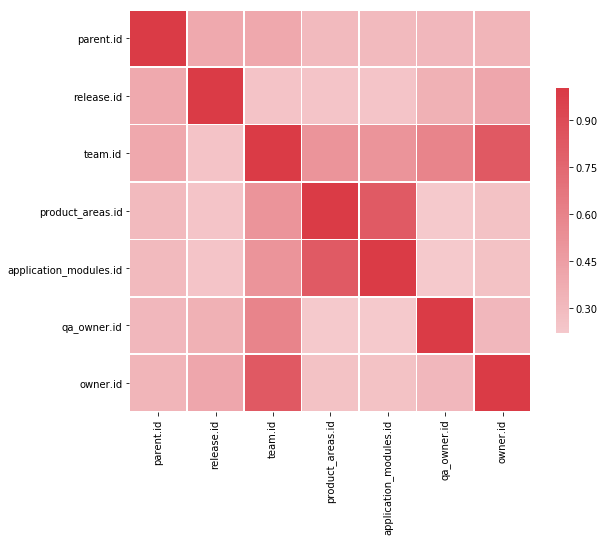

In [1139]:
def draw_corr(corr):
   # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(9, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, cmap=cmap, vmax=1.0, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}) 
    
draw_corr(small_corr_matrix)

# Data preparation

labels encoding

In [1140]:
# label envoding
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
le = LabelEncoder()
encoded_labels = pd.DataFrame(le.fit_transform(train_df['team.id']))
classes_number = encoded_labels.groupby(0).nunique().shape[0]
all_labels = encoded_labels[0].unique()
print('there are: ' + str(classes_number) + ' different labels in dataset, which corresponds to all teams')

there are: 29 different labels in dataset, which corresponds to all teams


In [1141]:
# ensure that the model is not overfitting 
# train & validation tests with labels, test without
xtrain, xvalid, ytrain, yvalid = train_test_split(X, encoded_labels,
                                                      stratify=encoded_labels,
                                                      random_state=42,
                                                      test_size=0.2, shuffle=True)


print ('train samples: ' + str(xtrain.shape) + ' validation samples: ' + str(xvalid.shape))

train samples: (17800, 17) validation samples: (4451, 17)


# Build Model + Classifier

Non Linear Model, parameters & structure taken from similar problem (Author identification)

preprocess(remove characters, stop words, lematization, NGrams) 

In [1142]:
from sklearn import metrics
# parameters:BATCH_SIZE=16, EPOC_SIZE=30
BATCH_SIZE = 16 # smaller batch size consume less memory (but can decrease accuracy)
EPOC_SIZE = 30
MIDDLE_LAYER_SIZE = 800
# for one hot encoded output, we use categorical 
loss_func = 'sparse_categorical_crossentropy' # 'categorical_crossentropy'
tokenizer_file_name = r"models" + os.sep + "2017Plus_er_" + str(BATCH_SIZE) + "B_" + str(EPOC_SIZE) + "E" + loss_func + "-Loss_" + str(MIDDLE_LAYER_SIZE) + "Layer.pkl"
classifier_file_name = r"models" + os.sep + "FTClassifier_" + str(BATCH_SIZE) + "B_" + str(EPOC_SIZE) + "E" + loss_func + "-Loss_" + str(MIDDLE_LAYER_SIZE) + "Layer.pkl"

class fasttext_classifier(object):
    def __init__(self):
        self.train_df = None
        self.train_X = None
        self.train_Y = None
        self.vslid_X = None
        self.valid_Y = None
        self.model = None
        self.hist = None
        self.last_accuracy_report = None
        self.tokenizer = None
        self.rare_train_words = []
        
    def get_last_acc(self):
        return self.last_accuracy_report
    
    def create_model(self, input_dim, classes_number, embedding_dims=32, optimizer='adam'):
        self.labels = all_labels
        self.model = Sequential()
        
        # we start off with an efficient embedding layer which maps
        # our vocab indices into embedding_dims dimensions
        print("input dim: " + str(input_dim))
        self.model.add(Embedding(input_dim=input_dim, output_dim=embedding_dims, input_length=256))
        # Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training time,
        # which helps prevent overfitting.
        self.model.add(Dropout(0.3))
        #This layer creates a convolution kernel that is convolved with the layer input over a single spatial (or temporal) dimension to produce a tensor of outputs. If use_bias is True, a bias vector is created and added to the outputs. Finally, if activation is not None, it is applied to the outputs as well.
        self.model.add(Conv1D(64,
                              5,
                              padding='valid',
                              activation='relu'))
        self.model.add(Dropout(0.3))
        self.model.add(MaxPooling1D())
        self.model.add(Flatten())
        self.model.add(Dense(MIDDLE_LAYER_SIZE, activation='relu'))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(classes_number,activation='softmax'))
        self.model.compile(loss=loss_func,
                           optimizer=optimizer,
                           metrics=['accuracy']) 

        
    def print_summary(self):
        print(self.model.summary())
    
        
    def set_tokenizer(self, tokenizer):
        self.tokenizer = tokenizer

    def train(self, docstrain, ytrain, docsvalid, yvalid):
        self.train_X = docstrain
        self.train_Y = ytrain
        self.hist = self.model.fit(docstrain, ytrain,
                                   batch_size=BATCH_SIZE,
                                   validation_data=(docsvalid, yvalid),
                                   epochs=EPOC_SIZE, verbose=2,
                                   callbacks=[EarlyStopping(patience=4, monitor='val_loss')])

        predictions = self.model.predict_proba(docsvalid)
        predictions_classes = self.model.predict_classes(docsvalid)
        try:
            # print("valid shape=" + str(yvalid.shape) + "predictions shape=" + str(predictions.shape) + "labels shape=" + str(self.labels.shape))
            self.last_accuracy_report = np.sum(predictions_classes == yvalid[0]) / len(yvalid[0])
            print("accuracy on validation set after training: %0.3f" % (
                self.last_accuracy_report))
#             print("prediction rows: " + str(len(predictions.values)))
#             print("prediction columns: " + str(len(predictions.values[0])))
#             print("fasttext logloss: %0.3f " % metrics.log_loss(yvalid[0].values, predictions.values, labels=self.labels[0].values))
        except Exception as e:
            print("Oops!! occured. could not calculate metrics for this epoc")
            print(e)
        return

    def predict(self, docstest):
        print("run prediction with trained")
        predictions = self.model.predict_proba(docstest)
        predictions_classes = self.model.predict_classes(docstest)
        return predictions, predictions_classes
    
    def plot_train_vs_val(self):
        hist = self.model.history
        hist_dict = hist.history
        # plot loss
        fig = plt.figure()
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
        plt.subplot(211)
        val_loss = hist_dict.get('val_loss')
        val_loss_line = plt.plot(val_loss, label='val_loss')
        plt.legend()
        loss = hist_dict.get('loss')
        plt.plot(loss, label='train_loss')
        plt.legend()
        plt.title("train and validation loss")
        plt.ylabel("loss")
        
        # plot accuracy
        plt.subplot(212)
        val_acc = hist_dict.get('val_acc')
        plt.plot(val_acc, label='val_acc')
        plt.legend()
        acc = hist_dict.get('acc')
        plt.plot(acc, label='train_acc')
        plt.legend()
        plt.title("Train and validation accuracy")
        plt.ylabel("accuracy")
        plt.xlabel("Epoch")

        fig.savefig("fast-text-itr-performance.pdf", format='pdf')

### Word embeddings

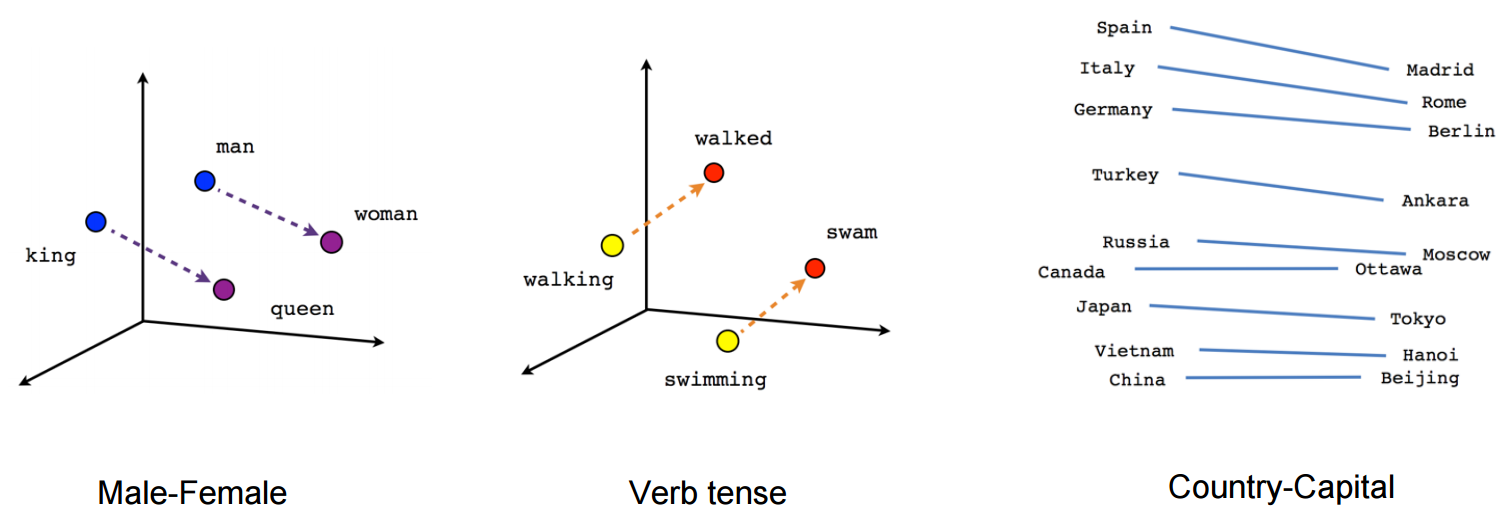

In [1143]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get("https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/06/06062705/Word-Vectors.png")
img = Image.open(BytesIO(response.content))
img

### Neural Net (Multi classification) Structure example

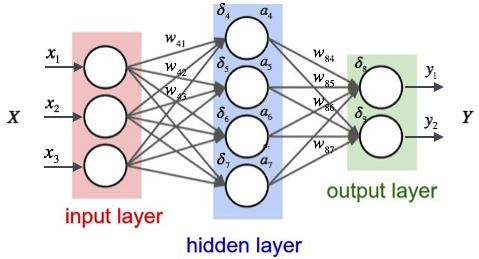

In [1144]:
response = requests.get("https://cdn-images-1.medium.com/max/1200/1*QVIyc5HnGDWTNX3m-nIm9w.png")
img = Image.open(BytesIO(response.content))
img

In [1145]:
from keras.layers import Dense, GlobalAveragePooling1D, Embedding
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn import model_selection
from sklearn import metrics
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import pickle

# preproceeings are:
# Separate punctuation from words
# Remove lower frequency words ( <= 2)
# Cut a longer document which contains 256 words
def preprocess(text, stop_words, lemmatizer):
    text = text.replace("' ", " ' ")
    signs = set(',.:;"?![]')
    prods = set(text) & signs
    
    if not prods:
        return text

    for sign in prods:
        text = text.replace(sign, ' {} '.format(sign))
    
    # Remove Stopwords
    if stop_words is not None:
        text = ' '.join([w for w in text.split(' ') if not w in stop_words])
    # Lematizing    
    if lemmatizer is not None:
        text = ' '.join([lemmatizer.lemmatize(w) for w in text.split(' ')])

    return text

# execute pre process for each of the docs (remove special characters)
def create_docs(data, n_gram_max=1, tokenizer=None, train_mode=True, referance_col='name', stop_words=None, lemmatizer=None):
    df = pd.DataFrame(data=data, columns=[referance_col])
    rare_train_words = []

    # create N grams + separate punctuation from words (character N grams)
    def add_ngram(q, n_gram_max):
        ngrams = []
        for n in range(2, n_gram_max + 1):
            for w_index in range(len(q) - n + 1):
                ngrams.append('--'.join(q[w_index:w_index + n]))
        return q + ngrams
    
    # pre-process text
    docs = []
    for doc in df[referance_col]:
        doc = preprocess(doc, stop_words, lemmatizer).split()
        docs.append(' '.join(add_ngram(doc, n_gram_max)))
        
    # tokenization step (why do not split on spaces?)
    min_count = 2
    if tokenizer is None:
        tokenizer = Tokenizer(lower=True, filters='')
        tokenizer.fit_on_texts(docs)
        # summarize what was learned in tokenizer
#         print(tokenizer.word_counts)
#         print(tokenizer.document_count)
#         print(tokenizer.word_index)
#         print(tokenizer.word_docs)

    if train_mode:
        # remove low frequency words
        num_words = sum([1 for _, v in tokenizer.word_counts.items() if v >= min_count])
        tokenizer = Tokenizer(num_words=num_words, lower=True, filters='')
        tokenizer.fit_on_texts(docs)

    docs = tokenizer.texts_to_sequences(docs)
    maxlen = 256
    # cat long sentences and
    docs = pad_sequences(sequences=docs, maxlen=maxlen)

    if train_mode:
        return docs, tokenizer
    else:
        return docs


# get fsx featurew for trainig and validation set in a cross validation methodology
def get_fasttext_features(xtrain, ytrain, xvalid, yvalid, referance_col, classes_number, all_labels, lbl_prefix='fastext_'):
    cv_scores = []
    pred_full_test = 0
    print('len ytrain = ' + str(len(set(ytrain))) + " len classes= " + str(classes_number))
    pred_train = np.zeros([xtrain.shape[0], classes_number])
    
    fsx = fasttext_classifier()
    
    print("create docs for train step (pre process, tokenization)")
    docstrain, tokenizer = create_docs(data=xtrain[referance_col], referance_col=referance_col)
    fsx.set_tokenizer(tokenizer)
    
    print("create docs for validation step (pre process, tokenization)")
    docstest = create_docs(data=xvalid[referance_col], tokenizer=fsx.tokenizer, train_mode=False,
                           referance_col=referance_col)
    input_dim = np.max(docstrain) + 1
    print("input embedding dim: " + str(input_dim))
    fsx.create_model(input_dim, classes_number=classes_number)

    # split training set to 5 folds
    kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
    cv_cnt = 1
    for dev_index, val_index in kf.split(docstrain):
        print("CV fsx:" + str(cv_cnt))
        cv_cnt += 1

        dev_X, val_X = docstrain[dev_index], docstrain[val_index]
        dev_y, val_y = ytrain.iloc[dev_index], ytrain.iloc[val_index]

        fsx.train(dev_X, dev_y, val_X, val_y)
        prob_val_y, cls_val_y = fsx.predict(val_X)
        prob_test_y, cls_test_y = fsx.predict(docstest)

        pred_full_test = pred_full_test + prob_test_y
        pred_train[val_index, :] = prob_val_y
#         try:
#             cv_scores.append(metrics.log_loss(val_y, prob_val_y, labels=all_labels))
#         except Exception as e:
#             print("valid shape=" + str(val_y.shape) + "predictions shape=" + str(prob_val_y.shape) + "labels shape=" + str(all_labels.shape))
#             print("Oops! failed to append log_loss metrics in KFold")
#             print(e)
#     try:
#         print("Mean cv score : ", np.mean(cv_scores))
#     except:
#         print("error while calculating mean cv score")
        
    pred_full_test = pred_full_test / 5.

    columns = [lbl_prefix + str(i) for i in range(classes_number)]
    aa = pd.DataFrame(columns=columns, data=pred_train)
    bb = pd.DataFrame(columns=columns, data=pred_full_test)
    return aa, bb


# this methos to be used to save model created on training set, for new row currently not in DB
def obtain_fasttext_model(xtrain, ytrain, xvalid, yvalid, classes_number, referance_col='name',
                          create_doc=True, is_stop_words=True, is_lematizing = False):

    fsx = fasttext_classifier()
    if is_stop_words:
        print("using stop words")
        eng_stopwords = set(stopwords.words("english"))
    else:
        eng_stopwords = None
        
    if is_lematizing:
        print("using lemmatizing")
        lemmatizer = WordNetLemmatizer()
    else:
        lemmatizer = None
        
    if create_doc:
        docstrain, tokenizer = create_docs(data=xtrain[referance_col], referance_col=referance_col,
                                           stop_words=eng_stopwords, lemmatizer=lemmatizer)
        fsx.set_tokenizer(tokenizer)
        docstest = create_docs(data=xvalid[referance_col], tokenizer=fsx.tokenizer, train_mode=False,
                           referance_col=referance_col, stop_words=eng_stopwords, lemmatizer = lemmatizer)
    else:
        docstrain=xtrain
        docstest=xvalid

    input_dim = np.max(docstrain) + 1
    fsx.create_model(input_dim, classes_number=classes_number)
    fsx.print_summary()
    
    fsx.train(docstrain, ytrain, docstest, yvalid)
    return fsx, tokenizer


xtrain_processed = xtrain.reset_index(drop=True)
xvalid_processed = xvalid.reset_index(drop=True)
    

# Train / Load Model

In [1146]:
train = True
is_stop_words=False
is_lematizing=True
if train:
    print("start training model...")
    fsx, tokenizer = obtain_fasttext_model(xtrain_processed, ytrain, xvalid_processed, yvalid, classes_number,
                                                             referance_col='name', is_stop_words=is_stop_words, is_lematizing=is_lematizing)
    print("finish training FT classifier")
    # export model and tokenizer
    pickle.dump(tokenizer, open(tokenizer_file_name, "wb"), protocol=pickle.HIGHEST_PROTOCOL)
    fsx.model.save(classifier_file_name)
else:
    # load model from disk
    import pickle
    from keras.models import load_model
    import pandas as pd
    loaded_tokenizer = pickle.load(open(tokenizer_file_name, "rb"))
    loaded_fsx = load_model(classifier_file_name)
    loaded_fsx.model.compile(loss=loss_func,
                           optimizer=optimizer,
                           metrics=['accuracy'])    

print("Exported model and tokenizer")

start training model...
using lemmatizing
input dim: 4650
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 256, 32)           148800    
_________________________________________________________________
dropout_85 (Dropout)         (None, 256, 32)           0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 252, 64)           10304     
_________________________________________________________________
dropout_86 (Dropout)         (None, 252, 64)           0         
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 126, 64)           0         
_________________________________________________________________
flatten_29 (Flatten)         (None, 8064)              0         
_________________________________________________________________
dense_101 (Dense) 

# Training VS Validation visualization 

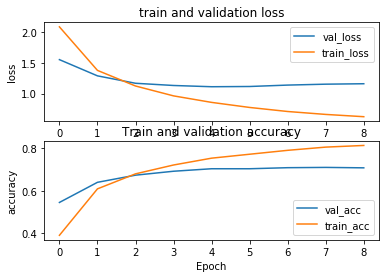

In [1147]:
if train:
    fsx.plot_train_vs_val()

# predict team by defect name

In [1148]:
def predict_with_model(docstest, model):
    print("run prediction with loaded model")
    predictions = model.predict_proba(docstest)
    predictions_classes = model.predict_classes(docstest)
    return predictions, predictions_classes

def predict_by_string(string_to_predict):
    column = pd.DataFrame({'name' : [string_to_predict]}) 
    if train:
        docs = create_docs(data=column, train_mode=False, tokenizer=tokenizer, referance_col='name')
        prob_val_matrix, y_class = fsx.predict(docs)
        predicted_team_id = le.inverse_transform(y_class)[0]
        team_probability = prob_val_matrix[0][y_class]
        predicted_sec_team_id = (-prob_val_matrix).argsort()[0][1]
    else:
        docs = create_docs(data=column, train_mode=False, tokenizer=loaded_tokenizer, referance_col='name')
        prob_val_matrix, y_class = predict_with_model(docs, loaded_fsx)
        predicted_team_id = le.inverse_transform(y_class)[0]
        # predicted_team_id = (-prob_val_matrix).argsort()[0][0]
        team_probability = prob_val_matrix[0][y_class]
    predicted_team_name = team_id_to_name_map[predicted_team_id]
    print (str(team_probability) + " probability it's: " + predicted_team_name + " labeled by " + str(y_class))


# Enter defect title for prediction

pipeline, coverage, dashboard, graphs, fortify, my items


In [1]:
predict_by_string("exception in jenkins plugin")

NameError: name 'predict_by_string' is not defined

## write classifier score to file

In [1150]:
classifier_score = "\nClassifier: " + classifier_file_name + " Lem:" + str(is_lemstizing) + " StopWords:" + str(is_stop_words) + " Validation Acc: " + str(fsx.get_last_acc())
f= open("accuracy_scores.txt","a")
f.write(classifier_score)
f.close()

# Round Two................

test different models, add fields for classifier (description?), extract additional fatures (syntactical? tfidf? BOW?)

# train test split: train, valid, test sets

## regularization

how to avoid overfitting
- reduce layers
- randomly neglect nodes from producing output in nn (dropout)
- add regularization (penelize for large weights: loss + x) L2 regularization

how to avoid underfitting - 
- encrease layers / nodes.
- add additional features.

to add regularization to layer:
model.add(Dense(5, input_shape=(26,), kernal.regulizer=regulizers.l2(0.01), activation='relu'))


# create the model with layers

In [1151]:
model = Sequential()
# Dense is a type of layer (basic type), fully connected layer
# first arg is number of neurons in layer
# the activation function getting the wieghted sum from all input nodes, and output a number between 0 to 1.
# the first layer is hidden layer (and the input defined with param input_shape)
model.add(Dense(5, input_shape=(50,), activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='softmax'))


In [1152]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_103 (Dense)            (None, 5)                 255       
_________________________________________________________________
dense_104 (Dense)            (None, 5)                 30        
_________________________________________________________________
dense_105 (Dense)            (None, 1)                 6         
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________


# compile the module

In [1153]:
# using optimizer (SGC, Adma..) , minimize the loss funtion.
# Adam is a variation of SGC, also choose loss func + metrics (printed out)
model.compile(Adam(lr=.0001), loss='binary_crossentropy', metrics=['accuracy'])

# train the model

In [1154]:
print("done")

done
